# Feature agglomeration vs. univariate selection

This example compares 2 dimensionality reduction strategies:

- feature agglomeration with Ward hierarchical clustering
- univariate feature selection with Anova

Both methods are compared in a regression problem using
a BayesianRidge as supervised estimator.


# Load modules
http://scikit-learn.org/stable/auto_examples/cluster/plot_feature_agglomeration_vs_univariate_selection.html

In [2]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause
import shutil
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, ndimage

from sklearn.feature_extraction.image import grid_to_graph
from sklearn import feature_selection
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import BayesianRidge
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.externals.joblib import Memory
from sklearn.cross_validation import KFold
# import seaborn.apionly

In [3]:
###############################################################################
# Generate data
n_samples = 200
size = 40  # image size
roi_size = 15
snr = 5.
np.random.seed(0)
mask = np.ones([size, size], dtype=np.bool)

coef = np.zeros((size, size))
coef[0:roi_size, 0:roi_size] = -1.
coef[-roi_size:, -roi_size:] = 1.

# Ground truth coefficients

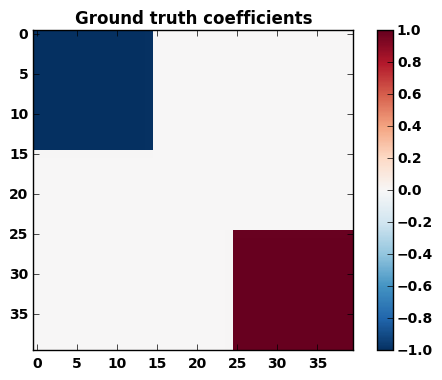

In [4]:
plt.imshow(coef)
plt.colorbar()
plt.title('Ground truth coefficients')

In [5]:
X = np.random.randn(n_samples, size ** 2)
for x in X:  # smooth data
    x[:] = ndimage.gaussian_filter(x.reshape(size, size), sigma=1.0).ravel()
X -= X.mean(axis=0)
X /= X.std(axis=0)

y = np.dot(X, coef.ravel())
noise = np.random.randn(y.shape[0])
noise_coef = (linalg.norm(y, 2) / np.exp(snr / 20.)) / linalg.norm(noise, 2)
y += noise_coef * noise  # add noise

# Ward agglomeration followed by BayesianRidge

In [9]:
###############################################################################
# Compute the coefs of a Bayesian Ridge with GridSearch
cachedir = tempfile.mkdtemp()
mem = Memory(cachedir=cachedir, verbose=0)

# Ward agglomeration followed by BayesianRidge
connectivity = grid_to_graph(n_x=size, n_y=size)

ward = FeatureAgglomeration(n_clusters=10, connectivity=connectivity,memory=mem)
ridge = BayesianRidge()
clf = Pipeline([('ward', ward), ('ridge', ridge)])

# Select the optimal number of parcels with grid search
cv = KFold(len(y), 2)  # cross-validation generator for model selection
clf = GridSearchCV(clf, {'ward__n_clusters': [10, 20, 30]}, n_jobs=1, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_agglomeration_ = coef_.reshape(size, size)

# Anova univariate feature selection followed by BayesianRidge

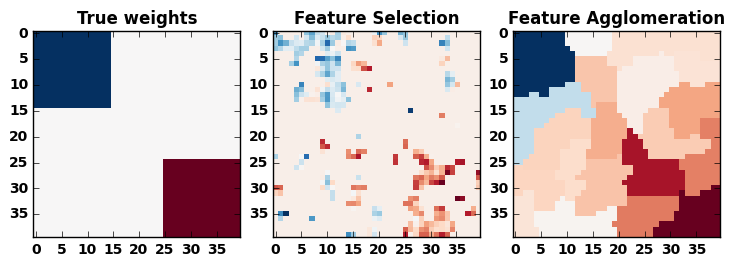

In [10]:
# Anova univariate feature selection followed by BayesianRidge
f_regression = mem.cache(feature_selection.f_regression)  # caching function
anova = feature_selection.SelectPercentile(f_regression)
clf = Pipeline([('anova', anova), ('ridge', ridge)])
# Select the optimal percentage of features with grid search
clf = GridSearchCV(clf, {'anova__percentile': [5, 10, 20]}, cv=cv)
clf.fit(X, y)  # set the best parameters
coef_ = clf.best_estimator_.steps[-1][1].coef_
coef_ = clf.best_estimator_.steps[0][1].inverse_transform(coef_)
coef_selection_ = coef_.reshape(size, size)

###############################################################################
# Inverse the transformation to plot the results on an image
plt.close('all')
plt.figure(figsize=(7.3, 2.7))
plt.subplot(1, 3, 1)
plt.imshow(coef, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("True weights")
plt.subplot(1, 3, 2)
plt.imshow(coef_selection_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Selection")
plt.subplot(1, 3, 3)
plt.imshow(coef_agglomeration_, interpolation="nearest", cmap=plt.cm.RdBu_r)
plt.title("Feature Agglomeration")
plt.subplots_adjust(0.04, 0.0, 0.98, 0.94, 0.16, 0.26)
plt.show()

# Attempt to remove the temporary cachedir, but don't worry if it fails
shutil.rmtree(cachedir, ignore_errors=True)